# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning I</font>

## Mini-Projeto 7
## Visão Computacional Para Reconhecimento de Placas de Trânsito

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


Este será um mini-projeto desafiador. Abaixo, você encontra um modelo de rede neural profunda completo e funcional. A partir de um dataset de imagens de placas de trânsito, o modelo é treinado e realiza previsões com aproximadamente 95% de acurácia em dados de teste. 

Seu trabalho será alterar o modelo e construir uma CNN com tudo que você aprendeu neste capítulo e atingir a maior acurácia possível. Não existe resposta certa para este mini-projeto. Seu modelo deve ter todas as técnicas já estudadas, como cálculo da perda, otimização, regularização, etc... Tente diversas abordagens e procure alcançar a máxima acurácia possível. Mas certifique-se que seu modelo não sofre de Overfitting.

### Dataset 

Para este mini-projeto, usaremos o dataset German Traffic Sign. Esse dataset foi usado na Conferência Conjunta Internacional sobre Redes Neurais (IJCNN) em 2011.

O conjunto de dados consiste em 39.209 imagens coloridas que devem ser usadas para treinamento e 12.630 imagens para teste. Cada imagem é uma foto de uma placa de trânsito pertencente a uma das 43 classes.

Aqui você encontra uma excelente documentação sobre o uso desse dataset para a construção de CNNs:

http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

Detalhes sobre o dataset podem ser obtidos aqui:

http://benchmark.ini.rub.de/

Mas disponibilizamos os arquivos para você no servidor da DSA, o Titan. O caminho está no código aqui no Jupyter Notebook.

### Importando os Pacotes Necessários

In [2]:
# Certifique-se que a GPU tem memória disponível
!nvidia-smi

Sat Mar 28 22:14:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   37C    P8     9W / 250W |    114MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

In [4]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [5]:
# Imports
import os
import random

# Imports para manipulação de dados
import pandas as pd
import numpy as np

# Imports para manipulação de imagens
from skimage import io,segmentation as seg
from PIL import Image

# Imports para visualização
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Divisão dos dados em treino e teste
import sklearn
from sklearn.model_selection import train_test_split

# Métrica de acurácia
from sklearn.metrics import accuracy_score

# Estilo de Formatação dos Gráficos
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

tensorflow                                 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf
matplotlib                                 3.2.1
seaborn                                    0.10.0
numpy                                      1.18.2
sklearn                                    0.22.2
pandas                                     1.0.3
PIL.Image                                  7.0.0
Data Science Academy


### Análise Exploratória dos Dados

#### Importando os Arquivos CSV com a Descrição das Imagens

In [7]:
# Metadatasets de treino e de teste

# Pasta no Titan
folder = "/media/datasets/DeepLearningI/Cap07/gtsrb-german-traffic-sign"

# Leitura dos arquivos csv
df_treino = pd.read_csv(folder + '/Train.csv')
df_teste  = pd.read_csv(folder + '/Test.csv')
df_meta   = pd.read_csv(folder + '/Meta.csv')

Vamos explorar os arquivos visualizando dados de amostra para entender os dados contidos nos 3 arquivos csv. 

In [8]:
# Dados de treino (veja a descrição de cada coluna logo abaixo)
df_treino.sample(4)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
5881,26,28,5,6,20,23,3,Train/3/00003_00028_00001.png
1029,33,34,6,6,27,28,1,Train/1/00001_00015_00009.png
9202,41,40,6,5,36,35,5,Train/5/00005_00025_00022.png
2983,33,35,6,6,28,29,2,Train/2/00002_00006_00013.png


In [9]:
# Dados de teste (veja a descrição de cada coluna logo abaixo)
df_teste.sample(4)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
5481,38,41,6,6,33,36,5,Test/05481.png
12417,49,49,5,5,44,44,4,Test/12417.png
2485,81,82,8,7,73,74,36,Test/02485.png
1179,60,61,6,5,55,56,9,Test/01179.png


#### Descrição das Colunas dos Datasets

Treino e teste têm as mesmas colunas que são:  

- Width  - Largura da imagem
    
- Height - Altura da imagem
    
- Roi.X1 - Coordenada da Região de Interesse X1
    
- Roi.Y1 - Coordenada da Região de Interesse Y1
    
- Roi.X2 - Coordenada da Região de Interesse X2
    
- Roi.Y2 - Coordenada da Região de Interesse Y1
    
- ClassId - Classe da Imagem, por exemplo: "20 km speed limit"
    
- Path - Caminho da Imagem no Sistema Operacional
    

O que é Roi?

Às vezes, é interessante processar uma única sub-região de uma imagem, mantendo outras regiões inalteradas. Isso geralmente é chamado de processamento de região de interesse (ROI). As sub-regiões da imagem podem ser convenientemente especificadas usando primitivas, como Ponto, Linha, Círculo, Polígono ou simplesmente como uma lista de posições de vértices.

Uma região de interesse (ROI) é uma parte da imagem na qual você deseja filtrar ou executar alguma outra operação. Você define uma ROI criando uma máscara binária, que é uma imagem binária do mesmo tamanho da imagem que deseja processar com pixels que definem a ROI definida como 1 e todos os outros pixels definidos como 0.

Esse conceito é estudado em detalhes no curso de Visão Computacional.

#### Explorando o Metafile

In [10]:
# Arquivo de metadados do dataset de imagens
df_meta.sample(4)

,Path,ClassId,ShapeId,ColorId,SignId
17,Meta/23.png,23,0,0,1.13
24,Meta/30.png,30,0,0,None
40,Meta/7.png,7,1,0,3.29
34,Meta/4.png,4,1,0,3.29


Descrição do Metafile:

O arquivo fornece meta informações sobre as classes fornecidas por este conjunto de dados.

- Path - Caminho para a imagem
- ClassId - ID da classe de imagem
- ShapeId - Forma do sinal de trânsito (triângulo 0, 1 círculo, 2 diamantes, 3 hexágonos e 4 inversos)
- ColorId - Cor do sinal (0-vermelho, 1-azul, 2-amarelo, 3-branco)
- SignId - ID do sinal (pela regra de tráfego ucraniano)

In [11]:
# Shape dos datasets
print("Treino: ", df_treino.shape)
print("Teste: ", df_teste.shape)
print("Meta: ", df_meta.shape)

Treino:  (39209, 8)
Teste:  (12630, 8)
Meta:  (43, 5)


O conjunto de dados de treino possui 39.209 linhas e 8 colunas.

O conjunto de dados de teste possui 12.630 linhas e 8 colunas.

Meta tem 43 linhas e 5 colunas.

#### Tipos de Dados

In [12]:
# Tipos dos dados de treino
print("Dataset de Treino\n")
df_treino.info()

Dataset de Treino

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [13]:
# Tipos dos dados de teste
print("Dataset de Teste\n")
df_teste.info()

Dataset de Teste

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


In [14]:
# Tipos dos dados no arquivo de metadados
print("Dataset de Metadados\n")
df_meta.info()

Dataset de Metadados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Path     43 non-null     object
 1   ClassId  43 non-null     int64 
 2   ShapeId  43 non-null     int64 
 3   ColorId  43 non-null     int64 
 4   SignId   43 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.8+ KB


Todas as colunas são numéricas, exceto Path que é um objeto (string), pois armazena o caminho para o diretório de imagens no sistema de arquivos e SignId que representa o sinal da placa de trânsito.

#### Resumo Estatístico

In [15]:
# Resumo estatístico em treino
print("Dataset de Treino")
df_treino.describe()

Dataset de Treino


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [16]:
# Resumo estatístico em teste
print("Dataset de Teste")
df_teste.describe()

Dataset de Teste


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [17]:
# Resumo estatístico dos dados no arquivo de metadados
print("Dataset de Metadados")
df_meta.describe()

Dataset de Metadados


,ClassId,ShapeId,ColorId
count,43.000000,43.000000,43.000000
mean,21.000000,0.790698,0.511628
std,12.556539,0.803508,0.935340
min,0.000000,0.000000,0.000000
25%,10.500000,0.000000,0.000000
50%,21.000000,1.000000,0.000000
75%,31.500000,1.000000,1.000000
max,42.000000,4.000000,3.000000


There are 42 image classes

#### Checando Duplicidades

In [18]:
print("Valores Duplicados em Treino: ", df_treino.duplicated().sum())
print("Valores Duplicados em Teste: ", df_teste.duplicated().sum())
print("Valores Duplicados em Metadados: ", df_meta.duplicated().sum())

Valores Duplicados em Treino:  0
Valores Duplicados em Teste:  0
Valores Duplicados em Metadados:  0


Não temos imagens duplicadas.

#### Distribuição de Contagem de Imagens Por Classe

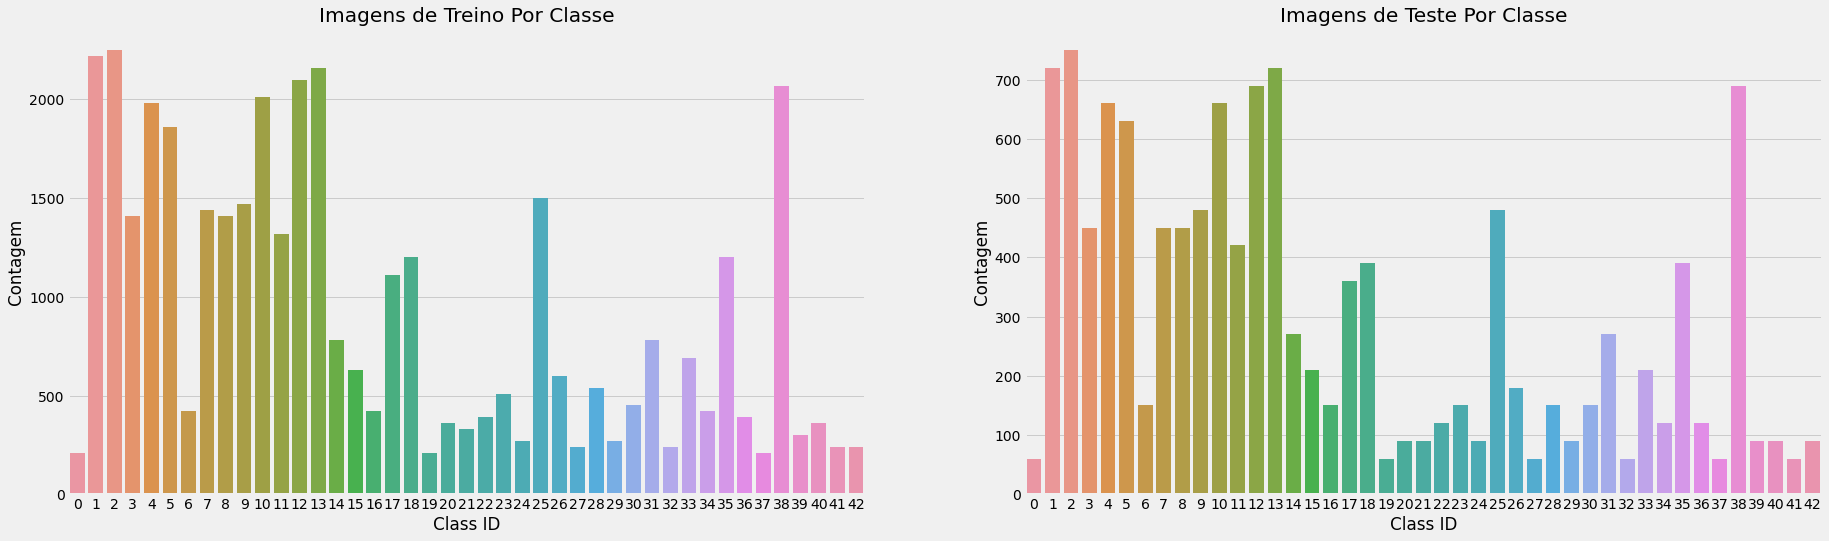

In [19]:
# Cria 2 subplots
fig, ax = plt.subplots(1, 2, figsize = (28, 8))

# Plot do histograma
sns.countplot(df_treino.ClassId, ax = ax[0])
sns.countplot(df_teste.ClassId, ax = ax[1])

# Labels dos gráficos
ax[0].set_title('Imagens de Treino Por Classe')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Contagem')
ax[0].set_xlabel('Class ID');

ax[1].set_title('Imagens de Teste Por Classe')
ax[1].set_xlabel('Classe')
ax[1].set_ylabel('Contagem')
ax[1].set_xlabel('Class ID');

### Importação das Imagens e Pré-Processamento

Para manipulação de imagem após a leitura do sistema de arquivos, as bibliotecas Pil ou Open CV podem ser usadas. PIL é usado abaixo. 

**Carregando Dados de Treino**

In [20]:
# Função para carregar as imagens de treino
def carregaImagensTreino(path, classes_count, height, width):

    # Listas para imagens e labels
    images = []
    labels = []
    
    # Classes a partir da contagem de classes
    classes = [i for i in range(classes_count)]
    
    # Loop pelas classes
    for classe in classes:
        
        # Anexa o caminho fornecido como argumento mais o valor da classe que é de 0 a 42, que são os 
        # subdiretórios no diretório das imagens de treino
        new_path = path + str (classe) + "/"
        
        # Retorna o nome do arquivo de imagem
        file_names = [os.path.join(new_path, f) for f in os.listdir(new_path)]
        
        # Para o arquivo de imagem, retorna imagem e label e adiciona às listas
        for file in file_names:
            
            # Carrega a imagem
            image = io.imread(file)
            
            # Cria o array da imagem
            image_from_array = Image.fromarray(image, 'RGB')
            
            # Redimensiona a imagem
            size_image = image_from_array.resize((height, width))
            
            # Adiciona a imagem à lista de imagens
            images.append(np.array(size_image))
            
            # Retorna o label da imagem e adiciona à lista de labels. Valores de 0 a 42.
            labels.append(classe)
            
    return images, labels

In [21]:
# Executa a função para carregar imagens de treino

# Parâmetros

# Path para os dados de treino
path_treino = "/media/datasets/DeepLearningI/Cap07/gtsrb-german-traffic-sign/Train/"

# Altura e largura da imagem
height = 30
width = 30

# Número de classes
classes_count_treino = df_treino['ClassId'].nunique()

# Executa a função
imagens_treino, labels_treino = carregaImagensTreino(path_treino, classes_count_treino, height, width)

In [22]:
# Checando shape das imagens carregadas
imagens_treino = np.array(imagens_treino)
labels_treino = np.array(labels_treino)
print("O Shape das imagens de treino é " + str(imagens_treino.shape))
print("O Shape dos labels de treino é " + str(labels_treino.shape))

O Shape das imagens de treino é (39209, 30, 30, 3)
O Shape dos labels de treino é (39209,)


São 39.209 imagens, cada uma com dimensão 30x30 e 3 canais de cores, RGB.

0

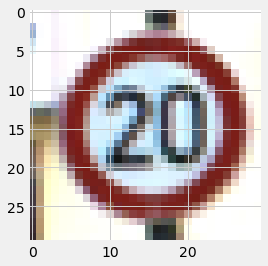

In [23]:
# Visualizando uma imagem de treino 
plt.imshow(imagens_treino[0])
labels_treino[0]

**Carregando Dados de Teste**

In [24]:
# Função para carregar as imagens de teste
def carregaImagensTeste(folder, lista_imagens, height, width):
    
    # Listas para imagens e labels
    images = []
    
    # Loop por cada imagem no diretório de imagens de teste
    for imagem in lista_imagens:
        
        # Carrega a imagem
        image = io.imread(folder + imagem)
        
        # Converte em array
        image_from_array = Image.fromarray(image, 'RGB')
        
        # Redimensiona a imagem
        size_image = image_from_array.resize((height, width))
        
        # Adiciona a imagem à lista de imagens
        images.append(np.array(size_image))
    
    return images

In [25]:
# Executa a função para carregar imagens de teste

# Parâmetros

# Path para os dados de teste
folder = "/media/datasets/DeepLearningI/Cap07/gtsrb-german-traffic-sign/"
lista_imagens = df_teste['Path'].values

# Altura e largura da imagem
height = 30
width = 30

# Executa a função
imagens_teste = carregaImagensTeste(folder, lista_imagens, height, width)

In [26]:
# Checando shape das imagens carregadas
imagens_teste = np.array(imagens_teste)
labels_teste = df_teste['ClassId'].values
print("O Shape das imagens de teste é: " + str(imagens_teste.shape))
print("O Shape dos labels de teste é: " + str(labels_teste.shape))

O Shape das imagens de teste é: (12630, 30, 30, 3)
O Shape dos labels de teste é: (12630,)


In [27]:
# Visualizando algumas imagens de teste

# Função para visualização de imagens
def visualizaImagemTeste(images, labels, images_count):
    for i in range(images_count):
        index = int(random.random() * len(images))
        plt.axis('off')
        plt.imshow(images[index])
        plt.show()
        
        print("O tamanho dessa imagem é: " + str(images[index].shape))
        print("A classe dessa imagem é: " + str(labels[index]))

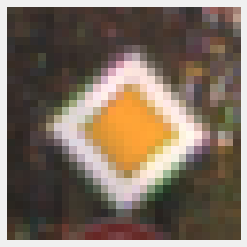

O tamanho dessa imagem é: (30, 30, 3)
A classe dessa imagem é: 12


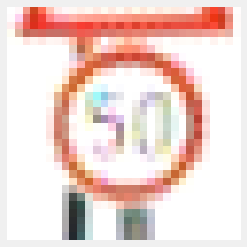

O tamanho dessa imagem é: (30, 30, 3)
A classe dessa imagem é: 2


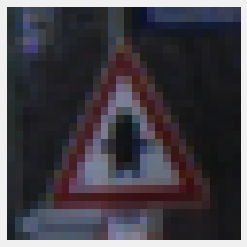

O tamanho dessa imagem é: (30, 30, 3)
A classe dessa imagem é: 11


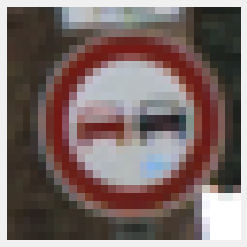

O tamanho dessa imagem é: (30, 30, 3)
A classe dessa imagem é: 9


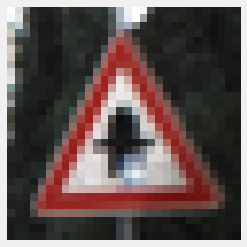

O tamanho dessa imagem é: (30, 30, 3)
A classe dessa imagem é: 11


In [28]:
# Executa a função
visualizaImagemTeste(imagens_teste, labels_teste, 5)

### Modelagem

#### Dividindo as imagens em conjuntos de treino e validação

Vamos deinir o dataset de validação como 20% de todas as imagens de treino. O motivo da divisão é poder ter a validação definida com rótulos. O conjunto de dados de teste fornecido não possui rótulos, portanto, não é o ideal para calcular a performance do modelo.

In [29]:
# Divisão dos dados de treino em dados de treino e validação
(X_treino, X_valid, label_X, label_valid) = train_test_split(imagens_treino, 
                                                              labels_treino, 
                                                              test_size = 0.2, 
                                                              random_state = 42)

# Print
print("O Shape de X_treino é " + str(X_treino.shape))
print("O Shape de label_X é " + str(label_X.shape))
print("O Shape de X_valid é " + str(X_valid.shape))
print("O Shape de label_valid é " + str(label_valid.shape))

O Shape de X_treino é (31367, 30, 30, 3)
O Shape de label_X é (31367,)
O Shape de X_valid é (7842, 30, 30, 3)
O Shape de label_valid é (7842,)


Normalmente, os valores RGB são codificados como números inteiros de 8 bits, que variam de 0 a 255. É um padrão usar 0,0f como preto e 1,0f como branco (brilho máximo), onde f significa float.

Para converter [0, 255] para [0.0f, 1.0f], divida por 255.0f. Isso é feito abaixo em nossa matriz de imagens de treino e validação.

In [30]:
# Normaliza os dados de entrada (imagens)
X_treino = X_treino.astype('float32')/255 
X_valid = X_valid.astype('float32')/255

In [31]:
# Converte os rótulos (labels) em tipo categórico
label_X = to_categorical(label_X, 43)
label_valid = to_categorical(label_valid, 43)

In [32]:
# Modelo CNN - Rede Neural Convolucional

# Cria a sequência de camadas
modelo = Sequential()

# Camada convolucional de entrada com filtro 5x5
modelo.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape = X_treino.shape[1:]))

# Camada convolucional interna (oculta) com filtro 3x3
modelo.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))

# Camada de MaxPooling para redução de dimensionalidade
modelo.add(MaxPool2D(pool_size = (2, 2)))

# Regularização com Dropout (evita overfitting)
modelo.add(Dropout(rate = 0.25))

# Outra camada convolucional interna (oculta) com filtro 3x3
modelo.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))

# Camada de MaxPooling para redução de dimensionalidade
modelo.add(MaxPool2D(pool_size = (2, 2)))

# Regularização com Dropout (evita overfitting)
modelo.add(Dropout(rate = 0.25))

# Ajusta o shape da saída anterior
modelo.add(Flatten())

# Camada densa, última camada oculta
modelo.add(Dense(256, activation = 'relu'))

# Regularização com Dropout (evita overfitting)
modelo.add(Dropout(rate = 0.5))

# Última camada com as previsões de probabilidade para cada uma das 43 classes
modelo.add(Dense(43, activation = 'softmax'))

In [33]:
# Sumário
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)         

In [34]:
# Compilação do Modelo
# Usamos função de custo categorical_crossentropy, ideal para classificação multiclasse
modelo.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
# Treinamento

# Número de epochs
epochs = 10

# Treinamento do modelo
historico_treino = modelo.fit(X_treino, label_X, 
                              batch_size = 32,  
                              epochs = epochs,
                              validation_data = (X_valid, label_valid))

Train on 31367 samples, validate on 7842 samples
Epoch 1/10
31367/31367 [==============================] - 8s 248us/step - loss: 1.1365 - accuracy: 0.6794 - val_loss: 0.1409 - val_accuracy: 0.9698
Epoch 2/10
31367/31367 [==============================] - 6s 207us/step - loss: 0.2091 - accuracy: 0.9365 - val_loss: 0.0555 - val_accuracy: 0.9870
Epoch 3/10
31367/31367 [==============================] - 6s 201us/step - loss: 0.1196 - accuracy: 0.9637 - val_loss: 0.0354 - val_accuracy: 0.9921
Epoch 4/10
31367/31367 [==============================] - 6s 204us/step - loss: 0.1019 - accuracy: 0.9688 - val_loss: 0.0401 - val_accuracy: 0.9902
Epoch 5/10
31367/31367 [==============================] - 6s 205us/step - loss: 0.0763 - accuracy: 0.9756 - val_loss: 0.0299 - val_accuracy: 0.9927
Epoch 6/10
31367/31367 [==============================] - 6s 199us/step - loss: 0.0725 - accuracy: 0.9787 - val_loss: 0.0295 - val_accuracy: 0.9945
Epoch 7/10
31367/31367 [==============================] - 6s 20

In [36]:
# Acurácia do Modelo em cada epoch
historico_treino.history['accuracy']

[0.6794083,
 0.93649375,
 0.96371984,
 0.968757,
 0.9756432,
 0.97870374,
 0.98230624,
 0.98125416,
 0.98374087,
 0.9852074]

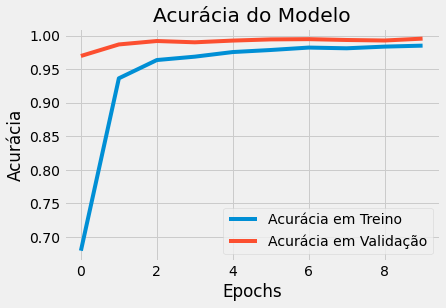

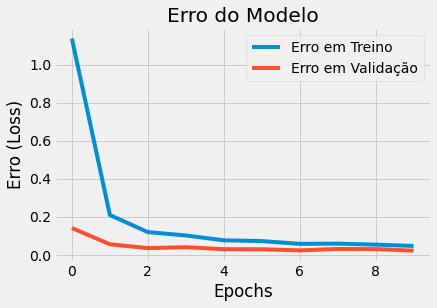

In [37]:
# Plot das métricas de acurácia e perda.
plt.figure(0)
plt.plot(historico_treino.history['accuracy'], label = 'Acurácia em Treino')
plt.plot(historico_treino.history['val_accuracy'], label = 'Acurácia em Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()

plt.figure(1)
plt.plot(historico_treino.history['loss'], label = 'Erro em Treino')
plt.plot(historico_treino.history['val_loss'], label = 'Erro em Validação')
plt.title('Erro do Modelo')
plt.xlabel('Epochs')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.show()

### Previsões do Modelo com Dados de Teste

In [38]:
# Aplicamos nas imagens de teste a mesma transformação aplicada nos dados de treino
imagens_teste = imagens_teste.astype('float32')/255  

In [39]:
# Shape
imagens_teste.shape

(12630, 30, 30, 3)

In [40]:
# Shape
labels_teste.shape

(12630,)

In [41]:
# Previsões do modelo
previsoes = modelo.predict_classes(imagens_teste)

In [42]:
# Acurácia em teste
accuracy_score(labels_teste, previsoes)

0.9722882026920031

Conseguimos 97% de acurácia em teste! Como podemos melhorar essa performance?

# Fim